# Training with Weights & Biases Integration

This notebook demonstrates iSAID instance segmentation training with full W&B tracking using the integrated `Trainer` class.

**Features:**
- Automatic logging of training/validation losses and metrics
- Gradient norm tracking for CBAM and RoI layers  
- Learning rate scheduling (OneCycleLR or ReduceLROnPlateau)
- Validation predictions visualization
- Model checkpointing as W&B artifacts
- mAP, mean IoU, and overfitting gap metrics

## 1. Setup

In [ ]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git

Cloning into 'isaid-instance-segmentation'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 483 (delta 123), reused 131 (delta 69), pack-reused 278 (from 1)
Receiving objects: 100% (483/483), 5.28 MiB | 26.13 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [ ]:
%cd isaid-instance-segmentation
!git pull

/content/isaid-instance-segmentation
Already up to date.


In [ ]:
import os
import sys
import gc
import numpy as np
import torch
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Set memory optimization for CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Available memory: 42.5 GB


In [ ]:
!pip install --upgrade wandb

In [ ]:
# Install wandb if not available
try:
    import wandb
    print(f"wandb version: {wandb.__version__}") # Must be newest
except ImportError:
    print("Installing wandb...")
    !pip install --upgrade wandb
    import wandb

wandb version: 0.24.0


### Kaggle wandb API setup

In [ ]:
from google.colab import userdata
my_secret = userdata.get('wandb_key')

# 2. Login explicitly (bypasses the interactive freeze)
wandb.login(key=my_secret)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marek-olnk (marek-olnk-put-pozna-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import importlib
import datasets.isaid_dataset
import models.maskrcnn_model
import training.transforms
import training.trainer

importlib.reload(datasets.isaid_dataset)
importlib.reload(models.maskrcnn_model)
importlib.reload(training.transforms)
importlib.reload(training.trainer)

from datasets.isaid_dataset import iSAIDDataset
from training.transforms import get_transforms
from training.trainer import Trainer, create_datasets
from models.maskrcnn_model import CustomMaskRCNN
from training.wandb_logger import ISAID_CLASS_LABELS

print("All modules imported successfully!")
print(f"\niSAID Class Labels:")
for idx, name in ISAID_CLASS_LABELS.items():
    print(f"  {idx}: {name}")

All modules imported successfully!

iSAID Class Labels:
  0: background
  1: ship
  2: storage_tank
  3: baseball_diamond
  4: tennis_court
  5: basketball_court
  6: ground_track_field
  7: bridge
  8: large_vehicle
  9: small_vehicle
  10: helicopter
  11: swimming_pool
  12: roundabout
  13: soccer_ball_field
  14: plane
  15: harbor


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaeloponteski/isaid-patches")

print("Path to dataset files:", path)

root_dir = path + "/iSAID_patches"
print("Root directory:", root_dir)

100%|██████████| 41.1G/41.1G [04:13<00:00, 174MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1
Root directory: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1/iSAID_patches


## 2. Configuration

In [ ]:
# All hyperparameters in one place - this will be logged to W&B
HYPERPARAMETERS = {
    # Dataset
    "data_root": root_dir,
    "num_classes": 16,
    "image_size": 800,

    # Training
    "batch_size": 8,
    "val_batch_size": 16,
    "num_epochs": 25,
    "learning_rate": 0.0003,
    "weight_decay": 0.001,
    "momentum": 0.9,

    # Model Architecture
    "backbone": "efficientnet_b0",
    "pretrained_backbone": True,
    "cbam_reduction_ratio": 16,
    "roi_head_layers": 4,

    # RPN Anchors (optimized for iSAID)
    "anchor_sizes": ((8, 16), (16, 32), (32, 64), (64, 128)),
    "aspect_ratios": ((0.5, 1.0, 2.0),) * 4,

    # W&B Logging
    "wandb_project": "isaid-custom-segmentation",
    "wandb_entity": "marek-olnk-put-pozna-",
    "wandb_log_freq": 10,  # Log every N batches
    "wandb_num_val_images": 4,  # Number of images for validation visualization
    "wandb_conf_threshold": 0.5,  # Confidence threshold for predictions
}

print("Hyperparameters:")
for k, v in HYPERPARAMETERS.items():
    print(f"  {k}: {v}")

Hyperparameters:
  data_root: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1/iSAID_patches
  num_classes: 16
  image_size: 800
  batch_size: 8
  val_batch_size: 16
  num_epochs: 25
  learning_rate: 0.0003
  weight_decay: 0.001
  momentum: 0.9
  backbone: efficientnet_b0
  pretrained_backbone: True
  cbam_reduction_ratio: 16
  roi_head_layers: 4
  anchor_sizes: ((8, 16), (16, 32), (32, 64), (64, 128))
  aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  wandb_project: isaid-custom-segmentation
  wandb_entity: marek-olnk-put-pozna-
  wandb_log_freq: 10
  wandb_num_val_images: 4
  wandb_conf_threshold: 0.5


## 3. Load Data

In [ ]:
# Create datasets
train_dataset, val_dataset = create_datasets(
    data_root=HYPERPARAMETERS["data_root"],
    image_size=HYPERPARAMETERS["image_size"],
    subset_fraction=1.0,  # Use full dataset
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Loading datasets...

DATASET STATISTICS: TRAIN

Image Counts:
   Original images:        28029
   Final images:           26431

Rejected Images (1598 total):
   - Too many boxes (>400): 230
   - Empty image excess:       1368

Box Distribution (final dataset):
   Empty images (0 boxes):  7929 (30.0%)
   Non-empty images:        18502

Box Count Statistics:
   Min:    0
   Max:    400
   Mean:   21.2
   Median: 3.0
   Std:    47.2

   Percentiles:
     25th: 0
     50th: 3
     75th: 18
     90th: 58
     95th: 106
     99th: 262


DATASET STATISTICS: VAL

Image Counts:
   Original images:        9512
   Final images:           8551

Rejected Images (961 total):
   - Too many boxes (>400): 62
   - Empty image excess:       899

Box Distribution (final dataset):
   Empty images (0 boxes):  2565 (30.0%)
   Non-empty images:        5986

Box Count Statistics:
   Min:    0
   Max:    400
   Mean:   22.0
   Median: 3.0
   Std:    48.0

   Percentiles:
     25th: 0
     50th: 3
     75th: 20

## 4. Create Model

In [ ]:
# Create model with custom anchor configuration
model = CustomMaskRCNN(
    num_classes=HYPERPARAMETERS["num_classes"],
    pretrained_backbone=HYPERPARAMETERS["pretrained_backbone"],
    rpn_anchor_sizes=HYPERPARAMETERS["anchor_sizes"],
    rpn_aspect_ratios=HYPERPARAMETERS["aspect_ratios"],
)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 68.3MB/s]


Total parameters: 24,315,626
Trainable parameters: 24,315,626


## 5. Create Trainer with W&B Integration

In [ ]:
# Create trainer with W&B integration
# The trainer handles all logging automatically!
trainer = Trainer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    batch_size=HYPERPARAMETERS["batch_size"],
    val_batch_size=HYPERPARAMETERS["val_batch_size"],
    lr=HYPERPARAMETERS["learning_rate"],
    device=device,
    use_amp=True,
    num_workers=4,
    # W&B configuration
    wandb_project=HYPERPARAMETERS["wandb_project"],
    wandb_entity=HYPERPARAMETERS["wandb_entity"],
    wandb_tags=["maskrcnn", "efficientnet", "cbam", "trainer-integrated"],
    wandb_notes="A100 Training with integrated Trainer class - EfficientNet backbone + CBAM + FPN",
    wandb_log_freq=HYPERPARAMETERS["wandb_log_freq"],
    wandb_num_val_images=HYPERPARAMETERS["wandb_num_val_images"],
    wandb_conf_threshold=HYPERPARAMETERS["wandb_conf_threshold"],
    hyperparameters=HYPERPARAMETERS,
)

print(f"\nW&B Run: {trainer.wandb_logger.run.name}")
print(f"URL: {trainer.wandb_logger.run.url}")

Using provided datasets: 26431 train, 8551 val samples
Using provided model
Optimizer parameter groups:
  Base params: 265 tensors, lr=3.00e-04
  RoI params:  34 tensors, lr=7.50e-05 (alpha=0.25)
Device: cuda
AMP enabled: True
Train samples: 26431
Val samples: 8551


W&B run initialized: sweet-glitter-21
View at: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/1iif5q0p
Selected 4 validation images for visualization
W&B logging enabled: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/1iif5q0p

W&B Run: sweet-glitter-21
URL: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/1iif5q0p


## 6. Training

The `Trainer.fit()` method handles everything:
- Training loop with gradient clipping and AMP
- Validation loss computation
- mAP and mean IoU metrics
- W&B logging (losses, gradients, predictions, checkpoints)
- Learning rate scheduling
- Best model saving

In [ ]:
# Run training!
# All W&B logging happens automatically inside trainer.fit()
history = trainer.fit(
    epochs=HYPERPARAMETERS["num_epochs"],
    save_dir="checkpoints",
    compute_metrics_every=1,  # Compute mAP every epoch
    max_map_samples=200,  # Limit samples for faster mAP computation
)

print("\nTraining complete!")

Using ReduceLROnPlateau scheduler (steps on validation mAP)

Epoch 1/25 | LR: 3.00e-04


Train Epoch 1:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 1 Results (Time: 1339.6s):
  Losses:
    Train: 0.9894
    Val:   0.8802
  Performance Metrics:
    Train mAP@0.5: 0.3769
    Val mAP@0.5:   0.3506 (primary metric)
    Val Mean IoU:  0.4874
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.092254
    mAP Gap (train-val): +0.0263
  Detailed Train Losses:
    loss_objectness: 0.0874
    loss_rpn_box_reg: 0.0775
    loss_classifier: 0.2431
    loss_box_reg: 0.2167
    loss_mask: 0.3648
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.3506
-> New best train mAP@0.5: 0.3769
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 2/25 | LR: 3.00e-04


Train Epoch 2:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 2 Results (Time: 1344.0s):
  Losses:
    Train: 0.7975
    Val:   0.8352
  Performance Metrics:
    Train mAP@0.5: 0.4998
    Val mAP@0.5:   0.4790 (primary metric)
    Val Mean IoU:  0.5224
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.036343
    mAP Gap (train-val): +0.0208
  Detailed Train Losses:
    loss_objectness: 0.0468
    loss_rpn_box_reg: 0.0567
    loss_classifier: 0.1812
    loss_box_reg: 0.2052
    loss_mask: 0.3075
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.4790
-> New best train mAP@0.5: 0.4998
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 3/25 | LR: 3.00e-04


Train Epoch 3:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 3 Results (Time: 1320.8s):
  Losses:
    Train: 0.7367
    Val:   0.8384
  Performance Metrics:
    Train mAP@0.5: 0.4973
    Val mAP@0.5:   0.4728 (primary metric)
    Val Mean IoU:  0.5145
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.032768
    mAP Gap (train-val): +0.0245
  Detailed Train Losses:
    loss_objectness: 0.0386
    loss_rpn_box_reg: 0.0503
    loss_classifier: 0.1624
    loss_box_reg: 0.1944
    loss_mask: 0.2910

Epoch 4/25 | LR: 3.00e-04


Train Epoch 4:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 4 Results (Time: 1308.2s):
  Losses:
    Train: 0.6981
    Val:   0.8063
  Performance Metrics:
    Train mAP@0.5: 0.5965
    Val mAP@0.5:   0.5286 (primary metric)
    Val Mean IoU:  0.5452
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.031638
    mAP Gap (train-val): +0.0680
  Detailed Train Losses:
    loss_objectness: 0.0335
    loss_rpn_box_reg: 0.0457
    loss_classifier: 0.1506
    loss_box_reg: 0.1870
    loss_mask: 0.2813
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.5286
-> New best train mAP@0.5: 0.5965
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 5/25 | LR: 3.00e-04


Train Epoch 5:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 5 Results (Time: 1391.0s):
  Losses:
    Train: 0.6715
    Val:   0.8384
  Performance Metrics:
    Train mAP@0.5: 0.6336
    Val mAP@0.5:   0.5215 (primary metric)
    Val Mean IoU:  0.5627
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.028727
    mAP Gap (train-val): +0.1121
  Detailed Train Losses:
    loss_objectness: 0.0298
    loss_rpn_box_reg: 0.0433
    loss_classifier: 0.1417
    loss_box_reg: 0.1812
    loss_mask: 0.2754
-> New best train mAP@0.5: 0.6336
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 6/25 | LR: 3.00e-04


Train Epoch 6:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 6 Results (Time: 1290.9s):
  Losses:
    Train: 0.6508
    Val:   0.8077
  Performance Metrics:
    Train mAP@0.5: 0.6697
    Val mAP@0.5:   0.5699 (primary metric)
    Val Mean IoU:  0.5602
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.027801
    mAP Gap (train-val): +0.0997
  Detailed Train Losses:
    loss_objectness: 0.0273
    loss_rpn_box_reg: 0.0413
    loss_classifier: 0.1353
    loss_box_reg: 0.1770
    loss_mask: 0.2698
-> New best val mAP@0.5: 0.5699
-> New best train mAP@0.5: 0.6697
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 7/25 | LR: 3.00e-04


Train Epoch 7:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 7 Results (Time: 1350.5s):
  Losses:
    Train: 0.6336
    Val:   0.7987
  Performance Metrics:
    Train mAP@0.5: 0.6260
    Val mAP@0.5:   0.5429 (primary metric)
    Val Mean IoU:  0.5784
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.026034
    mAP Gap (train-val): +0.0832
  Detailed Train Losses:
    loss_objectness: 0.0255
    loss_rpn_box_reg: 0.0399
    loss_classifier: 0.1294
    loss_box_reg: 0.1727
    loss_mask: 0.2661
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss

Epoch 8/25 | LR: 3.00e-04


Train Epoch 8:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 8 Results (Time: 1305.3s):
  Losses:
    Train: 0.6188
    Val:   0.8004
  Performance Metrics:
    Train mAP@0.5: 0.7004
    Val mAP@0.5:   0.5820 (primary metric)
    Val Mean IoU:  0.5844
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.027243
    mAP Gap (train-val): +0.1184
  Detailed Train Losses:
    loss_objectness: 0.0239
    loss_rpn_box_reg: 0.0384
    loss_classifier: 0.1244
    loss_box_reg: 0.1692
    loss_mask: 0.2628
-> New best val mAP@0.5: 0.5820
-> New best train mAP@0.5: 0.7004
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 9/25 | LR: 3.00e-04


Train Epoch 9:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 9 Results (Time: 1359.4s):
  Losses:
    Train: 0.6068
    Val:   0.7929
  Performance Metrics:
    Train mAP@0.5: 0.5974
    Val mAP@0.5:   0.5608 (primary metric)
    Val Mean IoU:  0.5773
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.026015
    mAP Gap (train-val): +0.0366
  Detailed Train Losses:
    loss_objectness: 0.0227
    loss_rpn_box_reg: 0.0373
    loss_classifier: 0.1203
    loss_box_reg: 0.1662
    loss_mask: 0.2604
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss

Epoch 10/25 | LR: 3.00e-04


Train Epoch 10:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 10 Results (Time: 1299.5s):
  Losses:
    Train: 0.5956
    Val:   0.8379
  Performance Metrics:
    Train mAP@0.5: 0.6902
    Val mAP@0.5:   0.5528 (primary metric)
    Val Mean IoU:  0.5799
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.023839
    mAP Gap (train-val): +0.1373
  Detailed Train Losses:
    loss_objectness: 0.0213
    loss_rpn_box_reg: 0.0363
    loss_classifier: 0.1165
    loss_box_reg: 0.1636
    loss_mask: 0.2579

Epoch 11/25 | LR: 3.00e-04


Train Epoch 11:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 11 Results (Time: 1321.8s):
  Losses:
    Train: 0.5869
    Val:   0.8541
  Performance Metrics:
    Train mAP@0.5: 0.7167
    Val mAP@0.5:   0.5553 (primary metric)
    Val Mean IoU:  0.5744
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.024640
    mAP Gap (train-val): +0.1613
  Detailed Train Losses:
    loss_objectness: 0.0203
    loss_rpn_box_reg: 0.0356
    loss_classifier: 0.1137
    loss_box_reg: 0.1618
    loss_mask: 0.2554
-> New best train mAP@0.5: 0.7167
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 12/25 | LR: 3.00e-04


Train Epoch 12:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 12 Results (Time: 1356.5s):
  Losses:
    Train: 0.5781
    Val:   0.8294
  Performance Metrics:
    Train mAP@0.5: 0.6239
    Val mAP@0.5:   0.5786 (primary metric)
    Val Mean IoU:  0.5838
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.023560
    mAP Gap (train-val): +0.0453
  Detailed Train Losses:
    loss_objectness: 0.0193
    loss_rpn_box_reg: 0.0348
    loss_classifier: 0.1109
    loss_box_reg: 0.1599
    loss_mask: 0.2532

Epoch 13/25 | LR: 1.50e-04


Train Epoch 13:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 13 Results (Time: 1349.1s):
  Losses:
    Train: 0.5478
    Val:   0.8761
  Performance Metrics:
    Train mAP@0.5: 0.6583
    Val mAP@0.5:   0.5246 (primary metric)
    Val Mean IoU:  0.5746
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.022327
    mAP Gap (train-val): +0.1337
  Detailed Train Losses:
    loss_objectness: 0.0160
    loss_rpn_box_reg: 0.0313
    loss_classifier: 0.1005
    loss_box_reg: 0.1530
    loss_mask: 0.2470

Epoch 14/25 | LR: 1.50e-04


Train Epoch 14:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 14 Results (Time: 1351.2s):
  Losses:
    Train: 0.5387
    Val:   0.8420
  Performance Metrics:
    Train mAP@0.5: 0.8082
    Val mAP@0.5:   0.5845 (primary metric)
    Val Mean IoU:  0.5834
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.020739
    mAP Gap (train-val): +0.2237
  Detailed Train Losses:
    loss_objectness: 0.0149
    loss_rpn_box_reg: 0.0302
    loss_classifier: 0.0972
    loss_box_reg: 0.1509
    loss_mask: 0.2455
-> New best val mAP@0.5: 0.5845
-> New best train mAP@0.5: 0.8082
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 15/25 | LR: 1.50e-04


Train Epoch 15:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 15 Results (Time: 1340.2s):
  Losses:
    Train: 0.5320
    Val:   0.8425
  Performance Metrics:
    Train mAP@0.5: 0.7682
    Val mAP@0.5:   0.6597 (primary metric)
    Val Mean IoU:  0.5871
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019999
    mAP Gap (train-val): +0.1084
  Detailed Train Losses:
    loss_objectness: 0.0144
    loss_rpn_box_reg: 0.0296
    loss_classifier: 0.0948
    loss_box_reg: 0.1491
    loss_mask: 0.2440
-> New best val mAP@0.5: 0.6597

Epoch 16/25 | LR: 1.50e-04


Train Epoch 16:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 16 Results (Time: 1344.5s):
  Losses:
    Train: 0.5266
    Val:   0.8788
  Performance Metrics:
    Train mAP@0.5: 0.7951
    Val mAP@0.5:   0.5814 (primary metric)
    Val Mean IoU:  0.5759
  Training Dynamics:
    Gradient Norm: 0.9583
    Loss Variance: 0.020436
    mAP Gap (train-val): +0.2137
  Detailed Train Losses:
    loss_objectness: 0.0140
    loss_rpn_box_reg: 0.0292
    loss_classifier: 0.0928
    loss_box_reg: 0.1479
    loss_mask: 0.2426

Epoch 17/25 | LR: 1.50e-04


Train Epoch 17:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 17 Results (Time: 1321.4s):
  Losses:
    Train: 0.5208
    Val:   0.8815
  Performance Metrics:
    Train mAP@0.5: 0.7613
    Val mAP@0.5:   0.5974 (primary metric)
    Val Mean IoU:  0.5802
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.021865
    mAP Gap (train-val): +0.1640
  Detailed Train Losses:
    loss_objectness: 0.0135
    loss_rpn_box_reg: 0.0289
    loss_classifier: 0.0911
    loss_box_reg: 0.1465
    loss_mask: 0.2408

Epoch 18/25 | LR: 1.50e-04


Train Epoch 18:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 18 Results (Time: 1344.6s):
  Losses:
    Train: 0.5177
    Val:   0.8916
  Performance Metrics:
    Train mAP@0.5: 0.8123
    Val mAP@0.5:   0.5973 (primary metric)
    Val Mean IoU:  0.5899
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.020894
    mAP Gap (train-val): +0.2150
  Detailed Train Losses:
    loss_objectness: 0.0134
    loss_rpn_box_reg: 0.0288
    loss_classifier: 0.0901
    loss_box_reg: 0.1456
    loss_mask: 0.2398
-> New best train mAP@0.5: 0.8123
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 19/25 | LR: 1.50e-04


Train Epoch 19:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 19 Results (Time: 1344.8s):
  Losses:
    Train: 0.5148
    Val:   0.9202
  Performance Metrics:
    Train mAP@0.5: 0.8144
    Val mAP@0.5:   0.6185 (primary metric)
    Val Mean IoU:  0.5756
  Training Dynamics:
    Gradient Norm: 0.9590
    Loss Variance: 0.020235
    mAP Gap (train-val): +0.1959
  Detailed Train Losses:
    loss_objectness: 0.0129
    loss_rpn_box_reg: 0.0284
    loss_classifier: 0.0890
    loss_box_reg: 0.1450
    loss_mask: 0.2394
-> New best train mAP@0.5: 0.8144
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 20/25 | LR: 7.50e-05


Train Epoch 20:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 20 Results (Time: 1352.8s):
  Losses:
    Train: 0.4989
    Val:   0.8861
  Performance Metrics:
    Train mAP@0.5: 0.7532
    Val mAP@0.5:   0.6586 (primary metric)
    Val Mean IoU:  0.5945
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019476
    mAP Gap (train-val): +0.0946
  Detailed Train Losses:
    loss_objectness: 0.0116
    loss_rpn_box_reg: 0.0267
    loss_classifier: 0.0838
    loss_box_reg: 0.1412
    loss_mask: 0.2356

Epoch 21/25 | LR: 7.50e-05


Train Epoch 21:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 21 Results (Time: 1342.8s):
  Losses:
    Train: 0.4944
    Val:   0.9181
  Performance Metrics:
    Train mAP@0.5: 0.8392
    Val mAP@0.5:   0.5955 (primary metric)
    Val Mean IoU:  0.5921
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019784
    mAP Gap (train-val): +0.2437
  Detailed Train Losses:
    loss_objectness: 0.0112
    loss_rpn_box_reg: 0.0262
    loss_classifier: 0.0820
    loss_box_reg: 0.1400
    loss_mask: 0.2349
-> New best train mAP@0.5: 0.8392
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 22/25 | LR: 7.50e-05


Train Epoch 22:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 22 Results (Time: 1560.3s):
  Losses:
    Train: 0.4908
    Val:   0.9214
  Performance Metrics:
    Train mAP@0.5: 0.7264
    Val mAP@0.5:   0.6340 (primary metric)
    Val Mean IoU:  0.5970
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019726
    mAP Gap (train-val): +0.0924
  Detailed Train Losses:
    loss_objectness: 0.0109
    loss_rpn_box_reg: 0.0260
    loss_classifier: 0.0805
    loss_box_reg: 0.1391
    loss_mask: 0.2342

Epoch 23/25 | LR: 7.50e-05


Train Epoch 23:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 23 Results (Time: 1429.1s):
  Losses:
    Train: 0.4874
    Val:   0.9740
  Performance Metrics:
    Train mAP@0.5: 0.8579
    Val mAP@0.5:   0.5958 (primary metric)
    Val Mean IoU:  0.5804
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019374
    mAP Gap (train-val): +0.2621
  Detailed Train Losses:
    loss_objectness: 0.0108
    loss_rpn_box_reg: 0.0258
    loss_classifier: 0.0797
    loss_box_reg: 0.1383
    loss_mask: 0.2329
-> New best train mAP@0.5: 0.8579
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 24/25 | LR: 7.50e-05


Train Epoch 24:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 24 Results (Time: 1353.3s):
  Losses:
    Train: 0.4854
    Val:   0.9722
  Performance Metrics:
    Train mAP@0.5: 0.7634
    Val mAP@0.5:   0.6130 (primary metric)
    Val Mean IoU:  0.5965
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019411
    mAP Gap (train-val): +0.1504
  Detailed Train Losses:
    loss_objectness: 0.0106
    loss_rpn_box_reg: 0.0256
    loss_classifier: 0.0787
    loss_box_reg: 0.1378
    loss_mask: 0.2327

Epoch 25/25 | LR: 3.75e-05


Train Epoch 25:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 25 Results (Time: 1348.9s):
  Losses:
    Train: 0.4769
    Val:   1.0196
  Performance Metrics:
    Train mAP@0.5: 0.8485
    Val mAP@0.5:   0.5697 (primary metric)
    Val Mean IoU:  0.5935
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.018963
    mAP Gap (train-val): +0.2788
  Detailed Train Losses:
    loss_objectness: 0.0100
    loss_rpn_box_reg: 0.0249
    loss_classifier: 0.0760
    loss_box_reg: 0.1356
    loss_mask: 0.2304

Training complete!
  Best val loss: 0.7929
  Best val mAP@0.5: 0.6597

Training complete!


In [ ]:
# Create artifact for the final trained model
artifact = wandb.Artifact(
    name="isaid-maskrcnn-final",
    type="model",
    description=f"Final trained Mask R-CNN model after {HYPERPARAMETERS['num_epochs']} epochs",
    metadata={
        "backbone": HYPERPARAMETERS["backbone"],
        "num_classes": HYPERPARAMETERS["num_classes"],
        "final_train_loss": history["train/loss"][-1],
        "final_val_loss": history["val/loss"][-1],
        "final_val_mAP": history["val/mAP@0.5"][-1],
        "best_val_mAP": max(history["val/mAP@0.5"]),
    }
)

# Add model checkpoint files
artifact.add_file("checkpoints/best.pth", name="best_model.pth")
artifact.add_file("checkpoints/best_map.pth", name="best_map_model.pth")
artifact.add_file("checkpoints/last.pth", name="last_model.pth")

# Log the artifact
trainer.wandb_logger.run.log_artifact(artifact)

print(f"Model artifacts saved to W&B!")
print(f"  - best_model.pth (lowest val loss)")
print(f"  - best_map_model.pth (highest val mAP)")
print(f"  - last_model.pth (final epoch)")

Model artifacts saved to W&B!
  - best_model.pth (lowest val loss)
  - best_map_model.pth (highest val mAP)
  - last_model.pth (final epoch)


## 7. Visualize Results

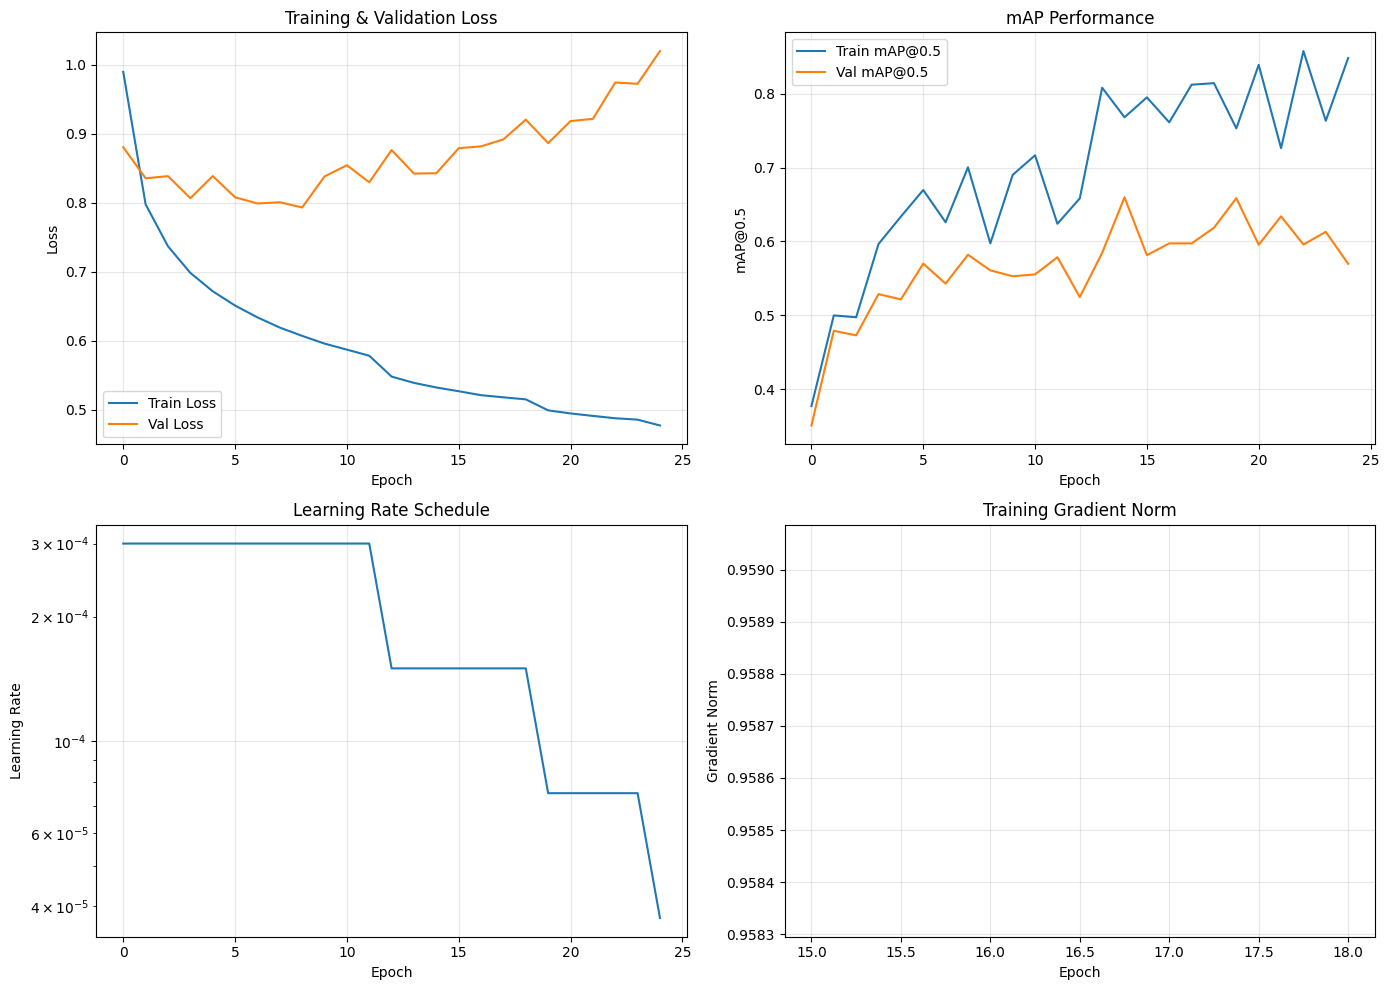

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
ax = axes[0, 0]
ax.plot(history["train/loss"], label="Train Loss")
ax.plot(history["val/loss"], label="Val Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training & Validation Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# mAP curves
ax = axes[0, 1]
ax.plot(history["train/mAP@0.5"], label="Train mAP@0.5")
ax.plot(history["val/mAP@0.5"], label="Val mAP@0.5")
ax.set_xlabel("Epoch")
ax.set_ylabel("mAP@0.5")
ax.set_title("mAP Performance")
ax.legend()
ax.grid(True, alpha=0.3)

# Learning rate
ax = axes[1, 0]
ax.plot(history["train/lr"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title("Learning Rate Schedule")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# Gradient norm
ax = axes[1, 1]
ax.plot(history["train/grad_norm"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Gradient Norm")
ax.set_title("Training Gradient Norm")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Visualize Predictions

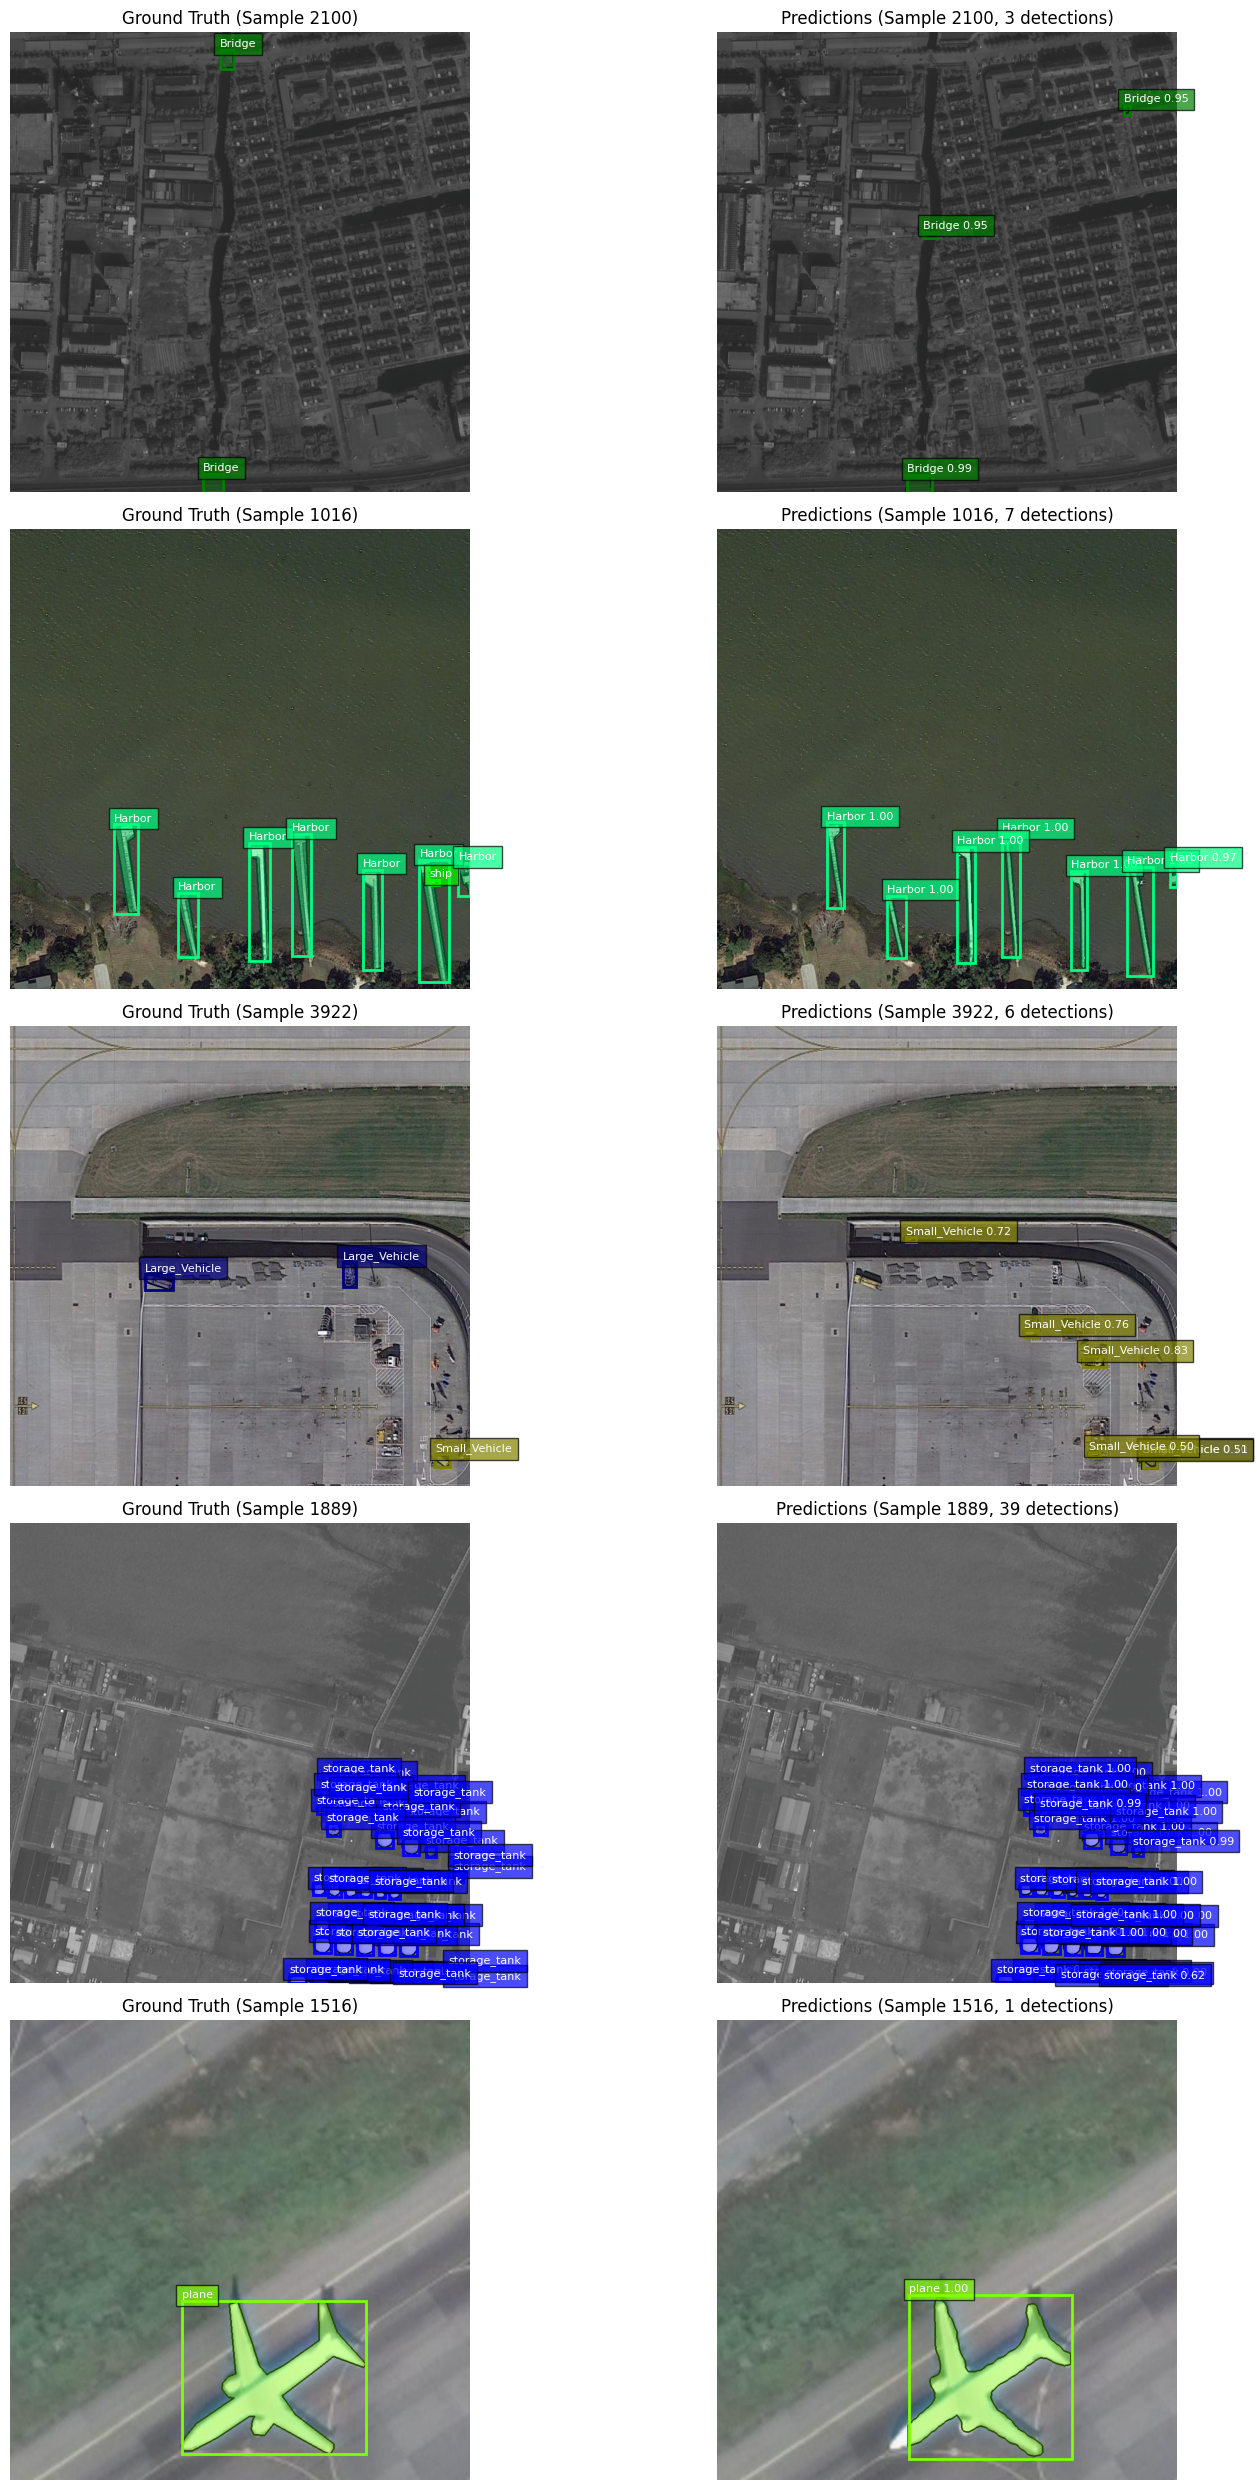

In [ ]:
# Visualize predictions on validation set
trainer.visualize_predictions(
    num_samples=5,
    score_threshold=0.5,
    mask_alpha=0.4,
)

## 9. Finish W&B Run

In [ ]:
# Finish the W&B run
trainer.finish()

print(f"\nW&B run completed!")
print(f"View results at: {trainer.wandb_logger.run.url}")

grads/backbone_norm,▁▁▃▂▄▁▃▂▃▃▄▃▃▄▅▁█▇▃▂▄▄▅▄▄▇▅▃▂▃▅▄█▇▅▄▆▃▄▆
grads/cbam_mean,▁▁▁▃▄▁▂▁▂▁▃▃▃▅▆▃▄▃▅▅▆▅▄▄▅▃▃▆▂▆▇▃▅▄▆▄█▄▅▃
grads/cbam_norm,▁▇▂▃▁▂▂▅▃▅▂▂▂▃▂▄▃▃▃▃▄▃▃▆▄▅▅▅▆▄▅▃▄▅█▄▆▄▆▅
grads/roi_head_mean,▇▇▇▇▅▇▆▅▅▁▇▄▃▅▅▆▅▄▅▄▆▁▅▆▃▄▃█▅▃▄▆▄▄▃▆▃▄▄▂
grads/roi_head_norm,█▇▅█▇█▇▃▇▆█▇▆▄▇▄▃▅▇▅▅▄▆▅▂▄▃▄▃▄▄▆▅▆▁▃▂▂▂▁
grads/total_norm,███████████████▇████████▁█▅████▄████████
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇███
train/learning_rate,██████████████████▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁
train/mask_loss,█▇▆▅▆▄▆▇▄▅▂▃▇▃▃▅▃▁▂▄▂▃▂▆▄▃▃▃▃▃▄▄▄▆▄▃▃▂▁▃
train/roi_box_loss,██▅▆▇▆▄▅▅▃▆▃▄▅▆▄▆██▃▅▅▄▁▄▅▇▃▄▂▄▂▆▃▆▄▂▂▄▂
+11,...


W&B run finished.
W&B run finished.

W&B run completed!
View results at: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/1iif5q0p


## 10. Load Model from W&B Artifact (Optional)

In [ ]:
# Example: Load best model from W&B artifacts
# Uncomment to use

# import wandb
# api = wandb.Api()
# artifact = api.artifact('YOUR_ENTITY/isaid-custom-segmentation/isaid-model:best')
# artifact_dir = artifact.download()
#
# model = CustomMaskRCNN(num_classes=16)
# model.load_state_dict(torch.load(f"{artifact_dir}/best_model.pth"))
# model.eval()
# print("Model loaded from W&B artifact!")